# 2) CNN, ImageDataGenerator, 전이학습 후 모델 저장 

#최종목표: CNN이미지를 바른자세와 非바른자세(어깨불균형,골반불균형,오다리)로 나뉘어 학습시킨 후  
#새로운 사진을 넣었을때 이미지를 분석하여 바른자세,비바른자세인지를 출력(사진하나로 전체측정)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, initializers, regularizers, metrics, Input, models, layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
#seed값 설정 
np.random.seed(3)
tf.compat.v1.set_random_seed(3)

#바른자세와 비바른자세로 이미지데이터 파일을 수집한 후 분류한다. 

#바른자세 40장, 非바른자세(어깨불균형,골반불균형,오다리) 120장 = 총 160장의 스켈레톤을 수집 

#과적합을 방지하기 위해서 학습셋과 테스트셋으로 나눈다.

#학습시킨 파일을 이미지증폭기(ImageDataGenerator)로 증가시킨다. 

#증폭시킨 파일을 딥러닝으로 학습시킨다. 

# 1. 이미지증폭기(ImageDataGenerator)

#주어진 데이터를 이용해서 변형된 이미지를 만들어 학습셋에 포함시키는 기능이며 이미지 데이터의 수를 확장할때 효과적 

In [3]:
#학습셋만 이미지부풀리기(과적합을 피하기 위해서)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   #주어진 이미지 크기를 바꾸어 준다. 값이 0~225의 RGB값을 가지고 있으므로 0~1로 바꿔준다.
                                  horizontal_flip=True, #주어진 이미지를 수평으로 뒤집니다.
                                  zoom_range=0.2, #정해진 범위 안에서 축소 또는 확대합니다.
                                  width_shift_range=0.1, # 정해진 범위안에서 정해진그림을 수평으로 10%랜덤하게 평행이동
                                  height_shift_range=0.1) #정해진 범위안에서 정해진그림을 수직으로 10%랜덤하게 평행이동

In [4]:
train_generator = train_datagen.flow_from_directory('C:\\Users\\flors\\1108 SKELETONED DATA\\train',
                                                   target_size = (150, 150), # 이미지크기 
                                                    batch_size = 5, # 샘플을 한번에 몇 개씩 처리할지를 정하는 부분 
                                                   class_mode = 'categorical')  # 다중 분류(클래스4개 : 바른자세, 어깨, 허리, 오다리)

Found 161 images belonging to 4 classes.


In [5]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,
                                  zoom_range=0.2,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1)#여기에 이거 안주면 accuracy가 더 낮다


In [6]:
test_generator = test_datagen.flow_from_directory('C:\\Users\\flors\\1108 SKELETONED DATA\\test',
                                                  target_size = (150, 150), 
                                                  batch_size = 5,
                                                  class_mode = 'categorical')

Found 32 images belonging to 4 classes.


# 2.전이학습: 기존의 학습결과를 가져와서 유사한 프로젝트에 사용하는 방법

#딥러닝의 모델을 학습할때 어떠한 픽셀의 조합을 선, 어떠한 형태의 그룹을 면이 되는지 파악해야한다. 

#아무런 정보없이 데이터를 판별할려면 많은 시간이 필요하므로 전이학습을 통해서 대용량의 데이터를 학습한 가중치를 

#가져와 내 모델에 적용하면 좀 더 높은 정확도를 얻을 수 있다. 

#VGGnet은 옥스폭드대학의 연구팀 VGG에 의해 개발된 모델로 2014년 이미지넷 인식대회에서 2위를 차지함 

#include_top (우리가 만든 로컬 네크워트를 연결한것인가?)= False
#또한 불러올 부분은 새롭게 학습되는 것이 아니므로 학습되지 않도록 transfer_model.trainable = False로 함 

In [7]:
transfer_model = VGG16(weights='imagenet', include_top = False, input_shape=(150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

#Trainable paramas:0 학습가능한 피라미터가 없음을 확인 

# 3.딥러닝모델 구현 

In [8]:
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64, activation='relu'))
finetune_model.add(Dense(4, activation='softmax'))
finetune_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                524352    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 15,239,300
Trainable params: 524,612
Non-trainable params: 14,714,688
_________________________________________________________________


In [9]:
finetune_model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

# 4.모델을 저장

In [27]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#모델 최적화 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):    #잘 만들어진 모델 저장하는 디렉토리
    os.mkdir(MODEL_DIR)

modelpath = "./model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)


In [28]:
history = finetune_model.fit_generator(train_generator, steps_per_epoch=len(train_generator), epochs=20,
                    validation_data = test_generator, validation_steps=4,callbacks=[early_stopping_callback, checkpointer])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

C:\Users\flors\anaconda3\envs\tf_2_4\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
33/33 [==============================] - 27s 780ms/step - loss: 1.3840 - accuracy: 0.3727 - val_loss: 1.3319 - val_accuracy: 0.4000

Epoch 00001: val_loss improved from inf to 1.33187, saving model to ./model\01-1.3319.hdf5
Epoch 2/20
33/33 [==============================] - 30s 904ms/step - loss: 1.2411 - accuracy: 0.4348 - val_loss: 1.1462 - val_accuracy: 0.5000

Epoch 00002: val_loss improved from 1.33187 to 1.14620, saving model to ./model\02-1.1462.hdf5
Epoch 3/20
33/33 [==============================] - 27s 807ms/step - loss: 1.0904 - accuracy: 0.5217 - val_loss: 1.2743 - val_accuracy: 0.4500

Epoch 00003: val_loss did not improve from 1.14620
Epoch 4/20
33/33 [==============================] - 25s 771ms/step - loss: 1.0789 - accuracy: 0.5714 - val_loss: 1.2953 - val_accuracy: 0.4500

Epoch 00004: val_loss did not improve from 1.14620
Epoch 5/20
33/33 [==============================] - 29s 869ms/step - loss: 0.9743 - accuracy: 0.6646 - val_loss: 1.0591 - val_accuracy: 

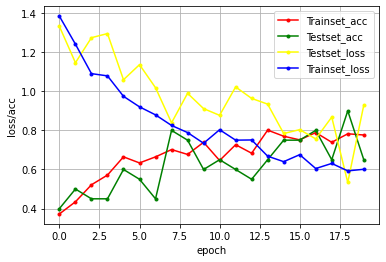

In [29]:
#그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, acc, marker='.', c='red', label='Trainset_acc')
plt.plot(x_len, val_acc, marker='.', c='green', label='Testset_acc')
plt.plot(x_len, y_vloss, marker='.', c='yellow', label = 'Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')

#그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()